In [1]:
import gurobipy as gb
import pandas as pd
import numpy as np

from extractor import extract_problem_data

In [13]:
filename = "instance_2.txt"

days, slots_per_day, nb_resources, nb_projects, resources, projects = extract_problem_data(filename=f"problems/{filename}")

In [14]:
squash_factor= 1 # value that indicate how much to squash the planning of the project. It need to be >= 1

# calculated data
total_time_slots = days * slots_per_day
BIG_M = max(2*total_time_slots, 99)
max_total_allocation = total_time_slots * nb_resources  # calculate max allocation
print("max_total_allocation", max_total_allocation)

max_total_allocation 80


In [15]:
env = gb.Env(empty=True)
env.setParam("OutputFlag", 0)
env.start()

model = gb.Model()

model.modelSense = gb.GRB.MINIMIZE  #declare minimization

In [16]:
# variables definition

X = {}
for p in range(nb_projects):
    for r in range(nb_resources):
        for t in range(total_time_slots):
            X[(p, r, t)] = model.addVar(vtype=gb.GRB.BINARY, name=f"X_p{p}_r{r}_t{t}")
S = {}
F = {}
for p in range(nb_projects):
    S[(p)] = model.addVar(vtype=gb.GRB.INTEGER, lb=0, ub=total_time_slots, name=f"S_p{p}")
    F[(p)] = model.addVar(vtype=gb.GRB.INTEGER, lb=0, ub=total_time_slots, name=f"F_p{p}")


Y = model.addVar(vtype=gb.GRB.INTEGER, lb=0, ub=total_time_slots, name=f"Y")

for v in model.getVars():
    print(v.varName)

In [17]:
# constraint 1
# Define constraint: Total working time for each project respect the request
for p in range(nb_projects):
    model.addConstr(sum(X[(p, r, t)] for r in range(nb_resources) for t in range(total_time_slots)) == projects[p].requested_slots)

# constraint 2
for p in range(nb_projects):
    for r in range(nb_resources):
        for t in range(total_time_slots):
            model.addConstr(t * X[(p, r, t)] <= F[p])

# constraint 3
for p in range(nb_projects):
    for r in range(nb_resources):
        for t in range(total_time_slots):
            model.addConstr(S[p] <= t*X[(p, r, t)]+(1-X[(p, r, t)])*BIG_M)

# constraint 4
# constraint assign lower bound of y
for p in range(nb_projects):
    model.addConstr(F[p] <= Y)

# constraint 5
for p in range(nb_projects):
    model.addConstr(F[p]-S[p]+1 <= projects[p].requested_slots*squash_factor)

# constraint 6
# constraints no double booking
for r in range(nb_resources):
    for t in range(total_time_slots):
        model.addConstr(sum(X[(p, r, t)] for p in range(nb_projects)) <= 1)

# constraint 7
# on each project only some resources can work on it
for project in projects:
    for resource in resources:
        if(not project.is_resource_assigned(resource)):
            for t in range(total_time_slots):
                model.addConstr(X[project.id, resource.id, t] == 0)
                
# constraint 8
# each task are planned to do not start before some specific time
for p in range(nb_projects):
    model.addConstr(S[p] >= projects[p].start_time)
    
# constraint 9
# each task are planned to do not finish after some specific time
for p in range(nb_projects):
    model.addConstr(F[p] <= projects[p].end_time)

    

In [18]:
model.setObjective(Y, gb.GRB.MINIMIZE)

In [19]:
print("Variables: ",model.NumVars)
print("Constraints: ",model.NumConstrs)

Variables:  0
Constraints:  0


In [20]:
model.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1085 rows, 411 columns and 2590 nonzeros
Model fingerprint: 0x81bdb867
Variable types: 0 continuous, 411 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+02]
Presolve removed 923 rows and 326 columns
Presolve time: 0.00s
Presolved: 162 rows, 85 columns, 394 nonzeros
Variable types: 0 continuous, 85 integer (74 binary)
Found heuristic solution: objective 15.0000000
Found heuristic solution: objective 14.0000000
Found heuristic solution: objective 7.0000000

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 4 (of 4 available processors)

Solution count 3: 7 14 

In [21]:
from Allocation import Allocation
from typing import List

# write the solution in the file
output_file = f"solutions/{filename}"  # Define the filename

# Open the file in write mode
with open(output_file, "w") as file:   
    # Check the status of the model
    status = model.Status
    if status == gb.GRB.INFEASIBLE:
        file.write("Model is infeasible\n")
    elif status == gb.GRB.UNBOUNDED:
        file.write("Model is unbounded\n")
    elif status == gb.GRB.INF_OR_UNBD:
        file.write("Model is infeasible or unbounded\n")
    elif status == gb.GRB.OPTIMAL:
        # Solution found and is optimal
        file.write("Optimal solution found\n")
    
        # Check the number of solutions
        sol_count = model.SolCount
        file.write(f"Number of solutions found: {sol_count}\n")
        file.write(f"Objective value: {model.ObjVal}\n")
        file.write(f"Solver runtime: {model.Runtime} seconds\n\n")
        
        
        allocations: List[Allocation]= []
        for project in projects:
            for resource in project.assigned_resources:
                for t in range(int(Y.x)):
                    if(X[(project.id, resource.id, t)].x == 1.0):
                        allocations.append(Allocation(project, resource, t))
        
        file.write(f"PROJECT SCHEDULE, nb_projects: {len(projects)}\n")
        for project in projects:
            file.write(f"Project_ID: {project.id}, resources_used: {len(project.allocations)}, requested_slots: {project.requested_slots}\n")
            for resource, value in project.allocations.items():
                file.write(f"Resource: {resource.id}, working: {value}\n")
            file.write("\n")
    
        # Resource POV allocation
        file.write(f"RESOURCE ALLOCATION, nb_resources: {len(resources)}\n")
        for resource in resources:
            file.write(f"Resource_ID: {resource.id}, allocations: {len(resource.allocations)}\n")
            for t in resource.allocations:
                file.write(f"t: {t}, project: {resource.allocations[t].id}\n")
            file.write("\n")        

    else:
        file.write(f"Optimization was stopped with status ={status}\n",)

In [22]:
np_array = np.zeros((nb_projects, nb_resources, total_time_slots))

# Populate the array with the values of the decision variables
for p in range(nb_projects):
    for r in range(nb_resources):
        for t in range(total_time_slots):
            if(X[(p, r, t)].x == 1.0):
                np_array[p, r, t] = 1

# cut the extra slot that are not used
max_time_slot = int(Y.x)

sliced_array = np_array[:, :, :max_time_slot+1]

reshaped_array = sliced_array.reshape(nb_projects * nb_resources, max_time_slot+1)

df = pd.DataFrame(reshaped_array)
df.index = [i for i in range(nb_resources)]*nb_projects # define the left header

print(df)

     0    1    2    3    4    5    6    7
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


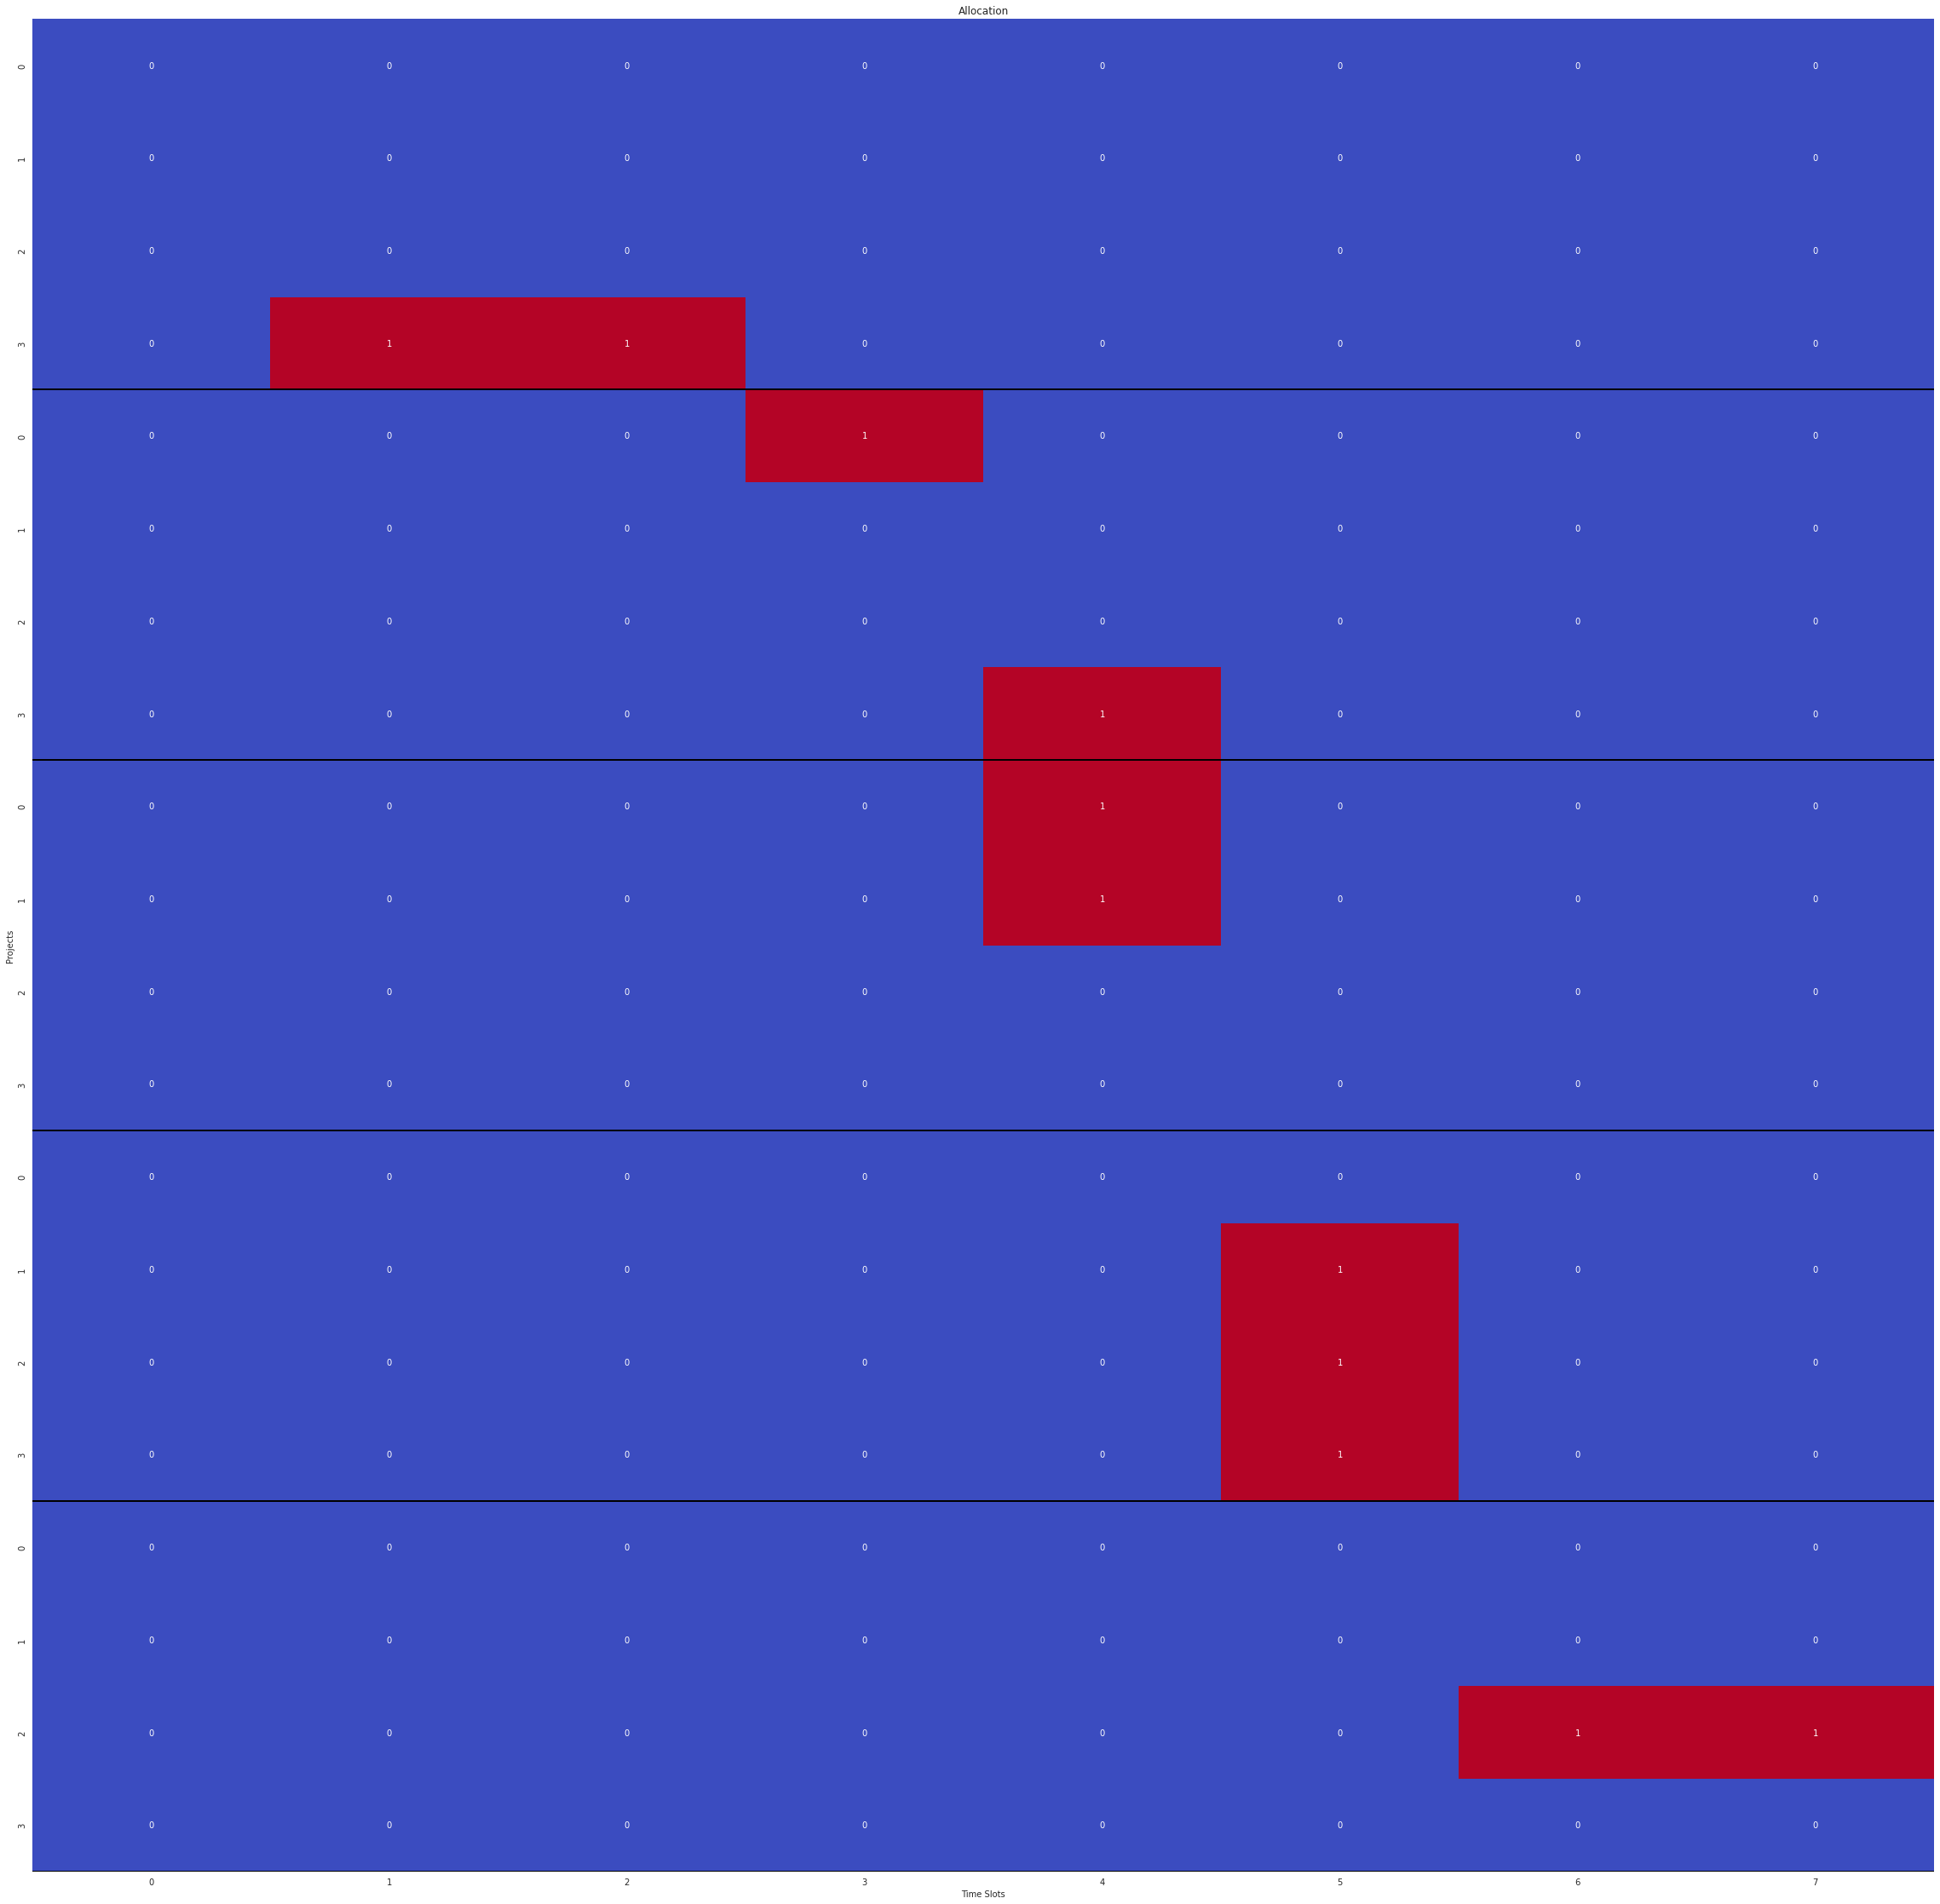

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap
plt.figure(figsize=(40, 40))  # Adjust the size as needed
# Add lines for separation
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='g', cbar=False)
group_end_indices = [nb_resources+i*nb_resources for i in range(nb_projects)]
for index in group_end_indices:
    plt.axhline(y=index, color='black', linewidth=2)

# Adding titles and labels for clarity
plt.title('Allocation')
plt.xlabel('Time Slots')
plt.ylabel('Projects')

plt.show()